# ECAPA-TDNNでの話者照合


Hugging Faceで公開されているECAPA-TDNNを用いて、話者照合を行いましょう。


環境構築が簡単なので、Google Colab上で実行することをお勧めします。


もし手元のPCで動かしたい、Google Colabの使い方が分からないなど要望があれば、いつでも相談してください！


 * Hugging Faceの公式ページ -> https://huggingface.co/

* 今回用いるECAPA-TDNNのページ ->https://huggingface.co/speechbrain/spkrec-ecapa-voxceleb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CS_seminar/4th/src/6p4s

/content/drive/MyDrive/CS_seminar/4th/src


In [ ]:
#pythonのバージョン確認
!python -V

Python 3.10.12


In [ ]:
#cudaのバージョン確認
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
#必要なライブラリのインストール
!pip install speechbrain
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib japanize-matplotlib typing scipy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.8/553.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 47.1 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=ce37767d2046fd66dd7b68c7959f9ebc3992cc138c12344c170c824165e5c363
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
  Cre

In [ ]:
#事前学習モデルのロード
from speechbrain.pretrained import SpeakerRecognition
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")

(…)a-voxceleb/resolve/main/hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

(…)eleb/resolve/main/mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

(…)-voxceleb/resolve/main/label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [ ]:
#2つの発話の話者が同じ場合の例
#verification.verify_files内の引数はモデルに入力したいwavファイルのパス
#scoreはコサイン類似度です (参照：https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/pretrained/interfaces.py)
score, prediction = verification.verify_files(
    "../../../_data/wav/ymgt/0.wav", "../../../_data/wav/ymgt/1.wav")  # Same Speaker

In [ ]:
print("score: ", score)

score:  tensor([0.4827])


In [ ]:
#2つの発話の話者が異なる場合の例
score, prediction = verification.verify_files(
    "../../../_data/wav/ymgt/0.wav", "../../../_data/wav/yskw/0.wav")  # Different Speakers

In [ ]:
print("score: ", score)

score:  tensor([0.1104])


## EERのプロット

In [ ]:
from typing import List
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from sklearn.metrics import roc_curve ,auc

In [ ]:
#EERを求める関数
#FRR=1-TPRであることに留意
def compute_eer(labels: List[int], scores: List[float]):
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
    eer_threshold = interp1d(fpr, thresholds)(eer)
    return fpr, tpr, thresholds, eer, eer_threshold

In [ ]:
#wavファイルのパスのペアと本人どうし(1)かそうじゃない(0)かをラベル付けしたファイルを用意する(サンプルも共有しておくので中身も確認してみてください)
#このファイルには"ラベル wav1 wav2"という風に書いてあるので、ファイルを1行ずつ読み込んで空白で区切って読み込んでいきます。
#ファイルの中身も自分たちが使う音声ファイルのパスに合わせてください。

filepath = "list.txt" #ここは任意に変更

labels = []
wav1 = []
wav2 = []

with open(filepath) as f:
  for line in f:
    line = line.rstrip().split(' ')
    labels.append(int(line[0]))
    wav1.append(line[1])
    wav2.append(line[2])


print(labels)
print(wav1)
print(wav2)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['../wav/ayu/0.wav', '../wav/ayu/0.wav', '../wav/ayu/0.wav', '../wav/ayu/1.wav', '../wav/ayu/1.wav', '../wav/ayu/2.wav', '../wav/ktg/0.wav', '../wav/ktg/0.wav', '../wav/kt

In [ ]:
scores = []
for i in range(len(labels)):
  score, prediction = verification.verify_files(wav1[i], wav2[i])
  scores.append(score.item())
print(scores)

[0.32704877853393555, 0.3657355308532715, 0.33069974184036255, 0.4197670817375183, 0.5264376401901245, 0.5106782913208008, 0.48778948187828064, 0.5562834739685059, 0.5194823145866394, 0.5073372721672058, 0.5972980260848999, 0.5298279523849487, 0.36119315028190613, 0.5841130018234253, 0.5607410669326782, 0.47490912675857544, 0.4630912244319916, 0.5774462223052979, 0.46151408553123474, 0.3365596532821655, 0.4254598915576935, 0.37755125761032104, 0.530266284942627, 0.4281793236732483, 0.48272904753685, 0.37403103709220886, 0.4733709692955017, 0.4800534248352051, 0.40281662344932556, 0.4596092104911804, 0.5234892964363098, 0.2649451196193695, 0.33025026321411133, 0.36447736620903015, 0.31695112586021423, 0.35971599817276, 0.027536392211914062, 0.2839677631855011, 0.06711671501398087, 0.09823387116193771, 0.09300552308559418, 0.11785884201526642, 0.10870827734470367, 0.12843294441699982, -0.06526154279708862, 0.08446447551250458, 0.031790394335985184, 0.076528400182724, 0.001634878106415271

In [ ]:
def gen_audio_cache_filename(wav_path):
  result = re.match(r".*/(.+?)/([_mn]+)/(.+?)\.wav", wav_path)
  spk, cond, wavname = result.groups()
  return f"{spk}-{cond}-{wavname}"

scores = []
for i in tqdm(range(len(labels))):
###
  waveform_x = verification.load_audio(
      wav1[i],
      save_filename=gen_audio_cache_filename(wav1[i])
      )
  waveform_y = verification.load_audio(
      wav2[i],
      save_filename=gen_audio_cache_filename(wav2[i])
      )
  # Fake batches:
  batch_x = waveform_x.unsqueeze(0)
  batch_y = waveform_y.unsqueeze(0)
  # Verify:
  score, decision = verification.verify_batch(batch_x, batch_y)
  # Squeeze:
  score, prediction = score[0], decision[0]
###
  scores.append(score.item())

print(scores)

In [ ]:
fpr, tpr, th, eer, eer_th = compute_eer(labels, scores)

In [ ]:
print("fpr: ", fpr)
print("tpr: ", tpr)
print("roc_th: ", th)
print("eer: ", eer)
print("eer_th: ", eer_th)

fpr:  [0.         0.         0.         0.00416667 0.00416667 0.00833333
 0.00833333 0.02083333 0.02083333 0.09166667 0.09166667 1.        ]
tpr:  [0.         0.02777778 0.83333333 0.83333333 0.88888889 0.88888889
 0.94444444 0.94444444 0.97222222 0.97222222 1.         1.        ]
roc_th:  [ 1.59729803  0.59729803  0.359716    0.34002528  0.33069974  0.33068782
  0.32704878  0.32384065  0.31695113  0.27063802  0.26494512 -0.09188519]
eer:  0.02777777777817793
eer_th:  0.3124106251723347


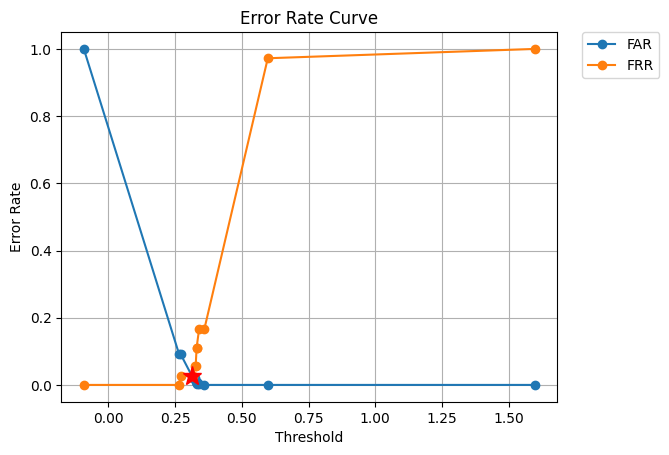

In [ ]:
#FAR,FRR,EERの図のプロット
import matplotlib.pyplot as plt
plt.plot(th, fpr, marker='o', label="FAR")
plt.plot(th, 1-tpr, marker='o', label="FRR")
plt.plot(eer_th,eer,marker='*', markersize=14, color="red")
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.title("Error Rate Curve")
plt.grid()

0.9961805555555555


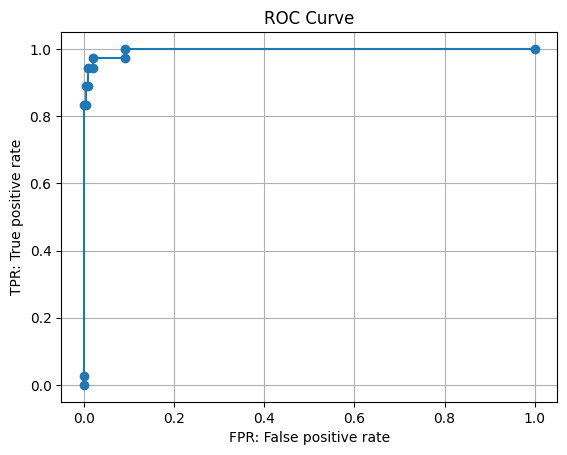

In [ ]:
#ROC曲線のプロット
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.title("ROC Curve")
plt.grid()
print(auc(fpr, tpr))

ちなみに，正しく照合できなかった発話対は…

In [ ]:
FNs = []
FPs = []
for idx in range(len(labels)):
  FN = labels[idx] == 1 and scores[idx] < eer_th # false negative, 偽陰性，同一だけど違う判定
  FP = labels[idx] == 0 and scores[idx] >= eer_th # false positive, 偽陽性, 異者だけど同一話者判定
  if FN:
    FNs.append((wav1[idx], wav2[idx]))
  if FP:
    FPs.append((wav1[idx], wav2[idx]))

print("--False Negatives:")
print(*FNs, sep='\n')
print("--False Positives:")
print(*FPs, sep='\n')

--False Negatives:
('../wav/yskw/0.wav', '../wav/yskw/2.wav')
--False Positives:
('../wav/ayu/2.wav', '../wav/tani/2.wav')
('../wav/ktg/0.wav', '../wav/shina/3.wav')
('../wav/ktg/1.wav', '../wav/shina/1.wav')
('../wav/ktg/1.wav', '../wav/shina/2.wav')
('../wav/ktg/2.wav', '../wav/tani/3.wav')
('../wav/tani/1.wav', '../wav/ymgt/1.wav')
('../wav/tani/1.wav', '../wav/ymgt/3.wav')
